In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from astropy.io import fits
from astropy.table import Table

In [2]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Cargar los datos a partir de los archivos FITS
path_datos = "../data/"
path = path_datos + "ZW2.msw_image.fits"
hdul = fits.open(path)

# Leer el archivo de texto con las posiciones de las galaxias
with open("galaxias_sextractor_marcos.txt", "r") as f:
    lines = f.readlines()

# Crear un ndarray de ceros con la misma forma que tus imágenes
label = np.zeros((2048, 2048), dtype=int)

# Función para mantener las coordenadas dentro de los límites de la imagen
def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

# Establecer a 1 las posiciones correspondientes a las galaxias
for line in lines:
    x, y, _ = line.split()
    x, y = int(float(x)), int(float(y))

    # Establecer 1 en un área de 8x8 píxeles alrededor de la posición central de cada galaxia
    for i in range(-4, 4):
        for j in range(-4, 4):
            x_coord = clamp(x + i, 0, 2047)
            y_coord = clamp(y + j, 0, 2047)
            label[y_coord, x_coord] = 1

In [4]:
# Cargar los datos y dividirlos en conjuntos de entrenamiento y validación
num_samples = len(hdul[0].data) # Cargar todos los datos en lugar de una muestra de 400 imágenes
all_data = hdul[0].data
indices = sorted(np.random.choice(all_data.shape[0], num_samples, replace=False))
data = all_data[indices]
input_data = np.array(data).astype("float32") / 255.0
input_data = input_data.reshape((data.shape[0], 1, data.shape[1], data.shape[2]))

output_data = np.repeat(label[np.newaxis, np.newaxis, :, :], data.shape[0], axis=0)

x_train, x_val, y_train, y_val = train_test_split(input_data, output_data, test_size=0.2, random_state=42)

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

train_data = TensorDataset(x_train, y_train)
val_data = TensorDataset(x_val, y_val)

tam_lote=2

train_loader = DataLoader(train_data, batch_size=tam_lote, shuffle=True)
val_loader = DataLoader(val_data, batch_size=tam_lote, shuffle=False)

He creado una arquitectura de red neuronal en PyTorch que es similar a la que tenía en TensorFlow. Aunque las dos redes son bastante parecidas en términos de estructura general y cantidad de capas, hay algunas diferencias clave:

Carga de todos los datos de hdul. Aprovechando el procesamiento gráfico disponible.

Alteración del learning rate y tamaño de los lotes (el tamaño de los lotes no se ha podido aumentar al final)

En lugar de utilizar tfa.layers.InstanceNormalization() en TensorFlow, he optado por usar nn.BatchNorm2d en PyTorch. Ambas capas tienen propósitos similares, que consisten en normalizar las características de las capas convolucionales para mejorar la estabilidad y el rendimiento del entrenamiento. Aunque no son exactamente lo mismo, nn.BatchNorm2d es una buena alternativa en PyTorch para este caso.

En la versión PyTorch, las funciones de activación ReLU están separadas de las capas convolucionales, mientras que en la versión TensorFlow, las funciones de activación ReLU están incluidas como un argumento en las capas convolucionales. A pesar de esta diferencia, la funcionalidad de la red no se ve afectada.

In [5]:
# Crear la CNN
encoder = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU()
)

decoder = nn.Sequential(
    nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.ConvTranspose2d(32, 1, 3, padding=1),
    nn.Sigmoid()
)

encoder = encoder.to(device)
decoder = decoder.to(device)

# Función de pérdida y optimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0005) # Cambiamos el learning rate de 0.001 a 0.0005

Epoch 1/30, Pérdida del train: 0.17760794128084348, Pérdida del test: 85.51667961707481
Epoch 2/30, Pérdida del train: 0.039246418399529324, Pérdida del test: 97.03695477496137
Epoch 3/30, Pérdida del train: 0.034945007061792745, Pérdida del test: 73.34226662772042
Epoch 4/30, Pérdida del train: 0.03293746205615915, Pérdida del test: 85.41772821447351
Epoch 5/30, Pérdida del train: 0.031697500264272094, Pérdida del test: 73.25200745299622
Epoch 6/30, Pérdida del train: 0.030753252419850066, Pérdida del test: 73.48570813189497
Epoch 7/30, Pérdida del train: 0.029875738830823038, Pérdida del test: 32.971141312148546
Epoch 8/30, Pérdida del train: 0.029220911438783838, Pérdida del test: 0.9767801388279422
Epoch 9/30, Pérdida del train: 0.02859619682033857, Pérdida del test: 2.583313281719501
Epoch 10/30, Pérdida del train: 0.028139275312423707, Pérdida del test: 97.19292525406722
Epoch 11/30, Pérdida del train: 0.027859006418536107, Pérdida del test: 2.70138219162658
Epoch 12/30, Pérdida 

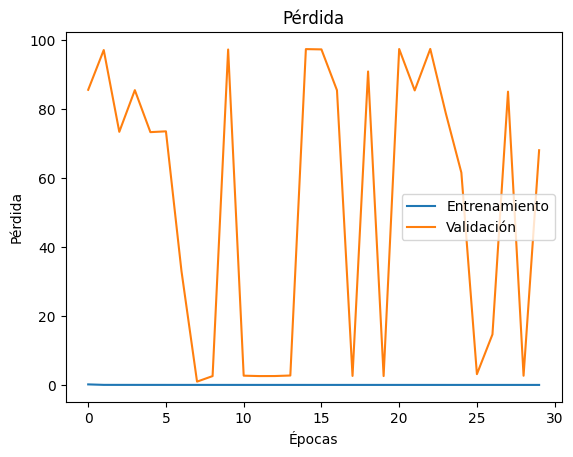

: 

In [6]:
# Entrenamiento
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        enc_output = encoder(images)
        dec_output = decoder(enc_output)

        # Convertir las etiquetas a float
        labels_float = labels.float()

        loss = criterion(dec_output, labels_float)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    train_losses.append(train_loss / len(train_loader))
    
    encoder.eval()
    decoder.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            enc_output = encoder(images)
            dec_output = decoder(enc_output)
            
            # Convertir las etiquetas a float
            labels_float = labels.float()
            
            loss = criterion(dec_output, labels_float)
            
            val_loss += loss.item()

    
    val_losses.append(val_loss / len(val_loader))
    
    print(f"Epoch {epoch+1}/{num_epochs}, Pérdida del train: {train_losses[-1]}, Pérdida del test: {val_losses[-1]}")

# Gráfico de pérdida
plt.plot(train_losses, label="Entrenamiento")
plt.plot(val_losses, label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'cnn_gpu_pytorch.pt')


In [ ]:
model.load_state_dict(torch.load('cnn_gpu_pytorch.pt'))
